Scene Classification using the UC Merced Land Use Dataset <br>
Reference: http://weegee.vision.ucmerced.edu/datasets/landuse.html

# Downloading the Dataset

In [1]:
# Download
!wget --quiet http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip

# Unzip
!unzip -qq UCMerced_LandUse.zip

In [2]:
# Look at the folders within the dataset
!ls UCMerced_LandUse/Images

agricultural	 denseresidential  mediumresidential  sparseresidential
airplane	 forest		   mobilehomepark     storagetanks
baseballdiamond  freeway	   overpass	      tenniscourt
beach		 golfcourse	   parkinglot
buildings	 harbor		   river
chaparral	 intersection	   runway


In [3]:
!pip install -q split-folders
import splitfolders

# Split the dataset into 80% training, 10% validation and 10% testing
splitfolders.ratio('UCMerced_LandUse/Images',
                   output='dataset',
                   seed=1337,
                   ratio=(0.8, 0.1, 0.1))

Copying files: 2100 files [00:01, 1731.06 files/s]


# Image Generators and Visualization

In [19]:
# https://keras.io/api/preprocessing/image/#flowfromdirectory-method

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1.0 / 255)
train = datagen.flow_from_directory('dataset/train', batch_size=64, seed=123)
val = datagen.flow_from_directory('dataset/val', seed=123)
test = datagen.flow_from_directory('dataset/test', seed=123)

Found 1680 images belonging to 21 classes.
Found 210 images belonging to 21 classes.
Found 210 images belonging to 21 classes.


In [20]:
import random
random.sample(range(100),10)

[14, 85, 31, 38, 6, 62, 91, 27, 45, 68]

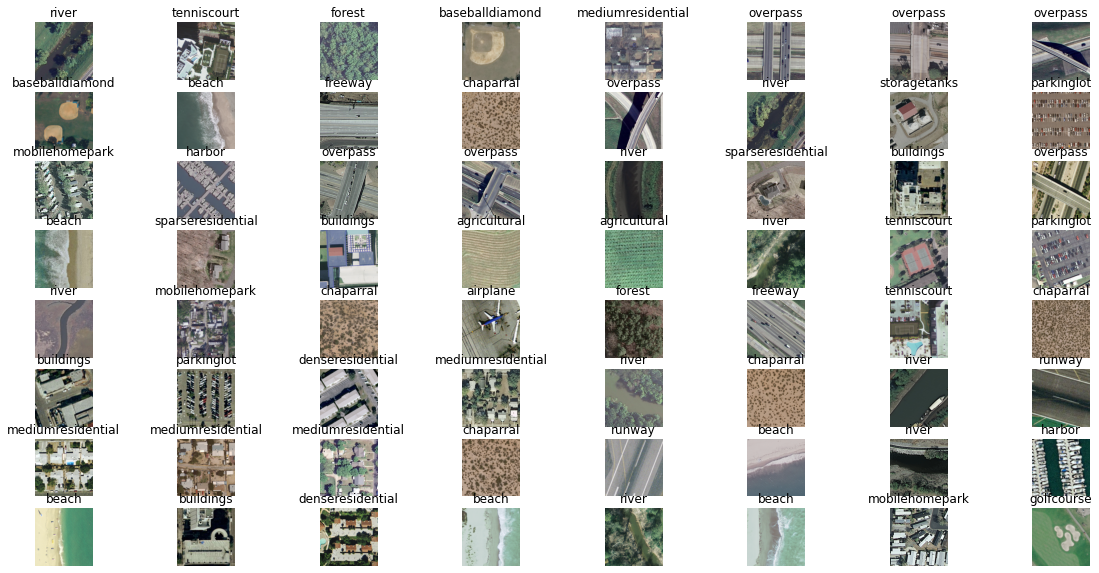

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Get the images from a batch
imgs = train.next()
labels = list(train.class_indices.keys())

# Plot
plt.figure(figsize=(20, 10))
cols, rows = 8, 8
for i in range(cols * rows):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[0][i])
    plt.title(labels[np.argmax(imgs[1][i])])
    plt.axis('off')

# Random Forest

In [12]:
import numpy as np

x_val, y_val = [], []

for i in range(5):
    
    images, classes = next(val)
    x_val.append(images.reshape(len(images), 256 * 256 * 3))
    y_val.append(np.argmax(classes, axis=1))

x_val = np.vstack(x_val)
y_val = np.hstack(y_val)

print(x_val.shape, y_val.shape)

(160, 196608) (160,)


In [16]:
# Training

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm.notebook import trange

val_scores = []
epochs = 10

rf = RandomForestClassifier(random_state=123, oob_score=True)
pbar = trange(1, epochs + 1)

for i in pbar:

    images, classes = next(train)
    x_train = images.reshape(len(images), 256 * 256 * 3)
    y_train = np.argmax(classes, axis=1)
  
    # Fit the model
    rf.fit(x_train, y_train)

    # Calculate the validation score
    val_score = rf.score(x_val, y_val)
    val_scores.append(val_score)

    # Update the progress bar
    pbar.set_postfix({'val': val_score, 'oob': rf.oob_score_})
    
    # Increase the trees for next batch
    rf.n_estimators += 20

In [17]:
# Saving the model
import joblib
joblib.dump(rf, 'SceneClassification_RF.joblib')

['SceneClassification_RF.joblib']

# MobileNet

In [18]:
# https://keras.io/api/applications/mobilenet/

# Importing the modules and model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Building the model
net = MobileNet(include_top=False, input_shape=(256, 256, 3))
model = Flatten()(net.output)
model = Dense(units=21, activation='softmax')(model)
model = Model(inputs=net.input, outputs=model)

# Training the model
model.compile(optimizer='adam', metrics=['accuracy'],
              loss='categorical_crossentropy')
model.fit(x=train, validation_data=val, epochs=2)

17227776/17225924 [==============================] - 0s 0us/step
Epoch 1/2
27/27 [==============================] - 438s 16s/step - loss: 7.3108 - accuracy: 0.4826 - val_loss: 74.0647 - val_accuracy: 0.3190
Epoch 2/2
27/27 [==============================] - 433s 16s/step - loss: 0.8531 - accuracy: 0.9202 - val_loss: 41.5153 - val_accuracy: 0.4381


In [ ]:
# Save the Model
model.save('SceneClassification_MobileNet.keras')

# Testing

In [22]:
import numpy as np

x_test, y_test = [], []

for i in range(5):
    
    images, classes = next(test)
    x_test.append(images.reshape(len(images), 256 * 256 * 3))
    y_test.append(np.argmax(classes, axis=1))

x_test = np.vstack(x_test)
y_test = np.hstack(y_test)

print(x_test.shape, y_test.shape)

(160, 196608) (160,)


0.18125


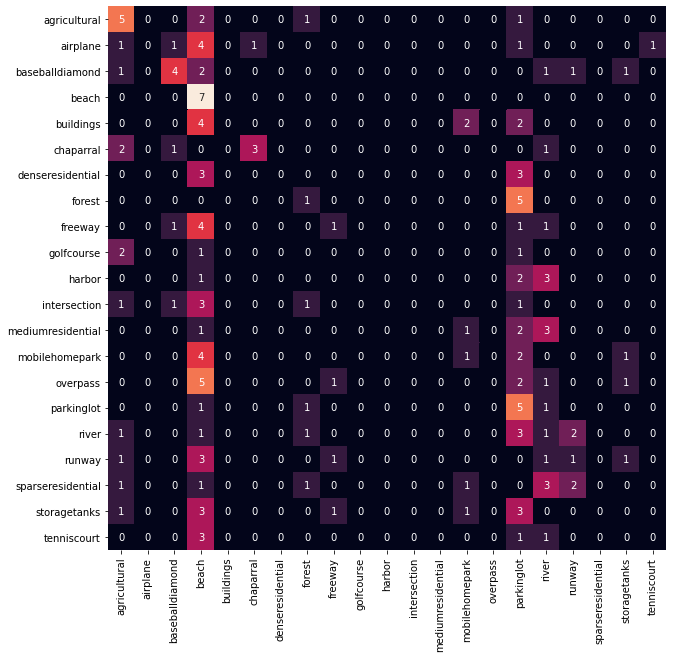

In [23]:
# Random Forest
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import joblib

# Load the model
rf_model = joblib.load('SceneClassification_RF.joblib')
rf_pred = rf_model.predict(x_test)
print(accuracy_score(y_test, rf_pred))

# Confusion matrix
cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cbar=False, fmt='d', xticklabels=labels,
            yticklabels=labels)
plt.show()

0.83125


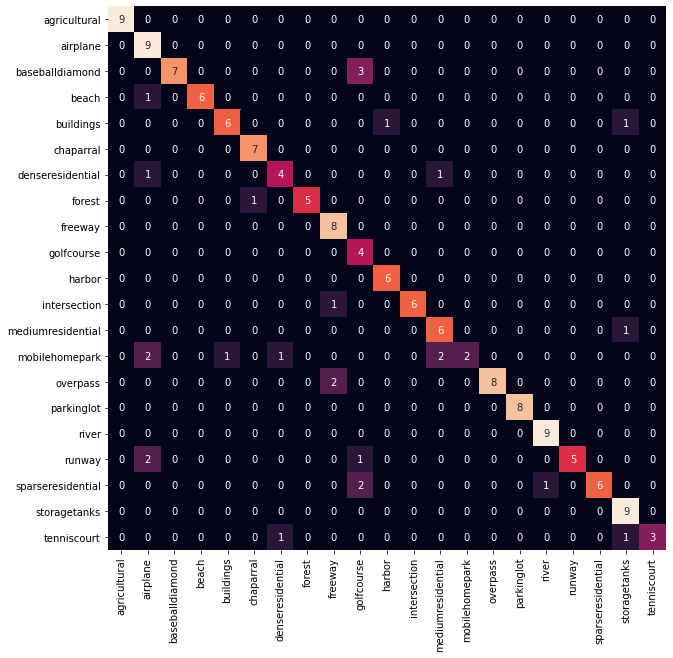

In [24]:
# Mobile Net
from tensorflow.keras.models import load_model

# Load the model and predict
mobile_net_model = load_model('SceneClassification_MobileNet.keras')
mn_pred = mobile_net_model.predict(x_test.reshape((160, 256, 256, 3)))
mn_pred = np.argmax(mn_pred, axis=1)
print(accuracy_score(y_test, mn_pred))

# Confusion matrix
cm = confusion_matrix(y_test, mn_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cbar=False, fmt='d', xticklabels=labels,
            yticklabels=labels)
plt.show()